In [21]:
import pandas as pd 
import xpresstools as xp
from scipy import stats
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import matplotlib.patches as patches

from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import FloatVector

%matplotlib inline

### Get data and clean up formatting

In [2]:
data = pd.read_csv('isrib_raw_counts.txt',sep='\t', index_col=0)

data.shape

(10941, 16)

### Threshold

In [3]:
data_t = data.loc[data.max(axis=1) > 25]

print(str(data.shape[0]) + ' genes before thresholding')
print(str(data_t.shape[0]) + ' genes before thresholding')

10941 genes before thresholding
10941 genes before thresholding


In [7]:
data_t.loc['UCP2']

isrib_a_hek_mrna        69
isrib_b_hek_mrna       130
tm_a_hek_mrna           44
tm_b_hek_mrna           51
tmisrib_a_hek_mrna      97
tmisrib_b_hek_mrna     187
untr_a_hek_mrna        143
untr_b_hek_mrna         97
ribo_isrib_a_ribo       31
ribo_isrib_b_ribo       43
ribo_tm_a_ribo         130
ribo_tm_b_ribo          98
ribo_tmisrib_a_ribo     96
ribo_tmisrib_b_ribo     78
ribo_untr_a_ribo        95
ribo_untr_b_ribo       108
Name: UCP2, dtype: int64

In [19]:
data_t.sum()

isrib_a_hek_mrna       11416295
isrib_b_hek_mrna        8759233
tm_a_hek_mrna           8860168
tm_b_hek_mrna          11237213
tmisrib_a_hek_mrna     17587001
tmisrib_b_hek_mrna     25312443
untr_a_hek_mrna        12128022
untr_b_hek_mrna        11149883
ribo_isrib_a_ribo       4624752
ribo_isrib_b_ribo       6116701
ribo_tm_a_ribo          4278374
ribo_tm_b_ribo          3079442
ribo_tmisrib_a_ribo     5999103
ribo_tmisrib_b_ribo     6664962
ribo_untr_a_ribo        8162699
ribo_untr_b_ribo       11760801
dtype: int64

### TPM Normalize

In [4]:
#Create length dictionary
len_dict = pd.read_csv('length_dict.txt',sep='\t', header=None, index_col=0)
del len_dict.index.name
len_dict.columns = ['length']
len_dict.length = len_dict.length / 1e3

#Perform RPK calculations
"""data_c = data_t.copy()
data_rpk = data_c.div(len_dict.length, axis=0)
data_rpk = data_rpk.dropna(axis=0)"""

#Perform per-million calculations
data_rpm = xp.rpm(data_t)

data_rpm.head()

,isrib_a_hek_mrna,isrib_b_hek_mrna,tm_a_hek_mrna,tm_b_hek_mrna,tmisrib_a_hek_mrna,tmisrib_b_hek_mrna,untr_a_hek_mrna,untr_b_hek_mrna,ribo_isrib_a_ribo,ribo_isrib_b_ribo,ribo_tm_a_ribo,ribo_tm_b_ribo,ribo_tmisrib_a_ribo,ribo_tmisrib_b_ribo,ribo_untr_a_ribo,ribo_untr_b_ribo
LOC388312,3.854140,6.849915,3.273076,3.559601,3.070450,4.780258,6.019118,5.291535,0.648683,0.163487,0.467467,0.324734,2.667065,1.650422,1.225085,0.000000
SAMD11,49.928633,56.968458,58.125309,48.232600,51.799622,56.177904,52.358084,56.144087,37.191183,35.967101,37.163651,30.849745,38.005682,35.559092,37.487601,40.133321
NOC2L,318.229338,304.935375,317.714066,321.343023,323.250110,299.496971,276.219816,307.716233,414.292485,428.008497,462.792640,445.210528,407.894314,386.048713,410.893505,435.004384
KLHL17,15.942125,17.010622,16.478243,12.547595,14.271905,15.012379,16.325828,13.991178,9.297796,8.174341,8.180678,9.417291,8.834654,9.602455,8.698103,8.332766
HES4,27.592139,29.112138,27.764711,27.408931,31.329958,33.264272,35.867349,39.462297,26.596021,25.994405,20.334828,18.509847,23.170131,27.306982,26.829361,27.974285


In [8]:
data_rpm.loc['UCP2']

isrib_a_hek_mrna        6.043992
isrib_b_hek_mrna       14.841482
tm_a_hek_mrna           4.966046
tm_b_hek_mrna           4.538492
tmisrib_a_hek_mrna      5.515437
tmisrib_b_hek_mrna      7.387671
untr_a_hek_mrna        11.790876
untr_b_hek_mrna         8.699643
ribo_isrib_a_ribo       6.703062
ribo_isrib_b_ribo       7.029933
ribo_tm_a_ribo         30.385375
ribo_tm_b_ribo         31.823947
ribo_tmisrib_a_ribo    16.002392
ribo_tmisrib_b_ribo    11.702992
ribo_untr_a_ribo       11.638307
ribo_untr_b_ribo        9.183048
Name: UCP2, dtype: float64

### Check replicate and RPF to RNA correlations (Fig 1E)

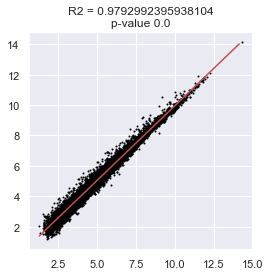

In [9]:
data_c = data_rpm.copy()

gene_a = data_c[['isrib_a_hek_mrna']].sum(axis=1).values.tolist()
gene_a = [x + 1 for x in gene_a]
gene_a = np.array(gene_a).astype(np.float)
gene_a = np.ndarray.tolist(gene_a)

gene_b = data_c[['isrib_b_hek_mrna']].sum(axis=1).values.tolist()
gene_b = [x + 1 for x in gene_b]
gene_b = np.array(gene_b).astype(np.float)
gene_b = np.ndarray.tolist(gene_b)

gene_a = np.log2(gene_a)
gene_b = np.log2(gene_b)

slope, intercept, r_value, p_value, std_err = stats.linregress(gene_a, gene_b)
x = np.linspace(np.amin(gene_a), np.amax(gene_b), 100)
y = (slope * x) + intercept

fig, ax = plt.subplots(1,1, figsize=(4,4))

ax.scatter(gene_a, gene_b, s=1,c='black')
ax.set_title('R2 = ' + str(r_value ** 2) + '\np-value ' + str(p_value))
ax.plot(x, y, '-r')

plt.show()

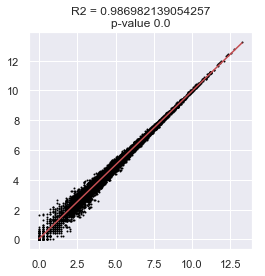

In [22]:
data_c = data_rpm.copy()

gene_a = data_c[['ribo_isrib_a_ribo']].sum(axis=1).values.tolist()
gene_a = [x + 1 for x in gene_a]
gene_a = np.array(gene_a).astype(np.float)
gene_a = np.ndarray.tolist(gene_a)

gene_b = data_c[['ribo_isrib_b_ribo']].sum(axis=1).values.tolist()
gene_b = [x + 1 for x in gene_b]
gene_b = np.array(gene_b).astype(np.float)
gene_b = np.ndarray.tolist(gene_b)

gene_a = np.log2(gene_a)
gene_b = np.log2(gene_b)

slope, intercept, r_value, p_value, std_err = stats.linregress(gene_a, gene_b)
x = np.linspace(np.amin(gene_a), np.amax(gene_b), 100)
y = (slope * x) + intercept

fig, ax = plt.subplots(1,1, figsize=(4,4))

ax.scatter(gene_a, gene_b, s=1,c='black')
ax.set_title('R2 = ' + str(r_value ** 2) + '\np-value ' + str(p_value))
ax.plot(x, y, '-r')

plt.show()

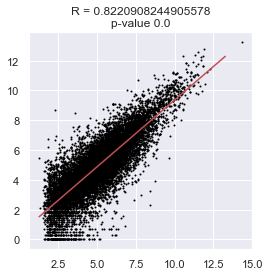

In [11]:
data_c = data_rpm.copy()

gene_a = data_c[['isrib_a_hek_mrna']].sum(axis=1).values.tolist()
gene_a = [x + 1 for x in gene_a]
gene_a = np.array(gene_a).astype(np.float)
gene_a = np.ndarray.tolist(gene_a)

gene_b = data_c[['ribo_isrib_a_ribo']].sum(axis=1).values.tolist()
gene_b = [x + 1 for x in gene_b]
gene_b = np.array(gene_b).astype(np.float)
gene_b = np.ndarray.tolist(gene_b)

gene_a = np.log2(gene_a)
gene_b = np.log2(gene_b)

slope, intercept, r_value, p_value, std_err = stats.linregress(gene_a, gene_b)
x = np.linspace(np.amin(gene_a), np.amax(gene_b), 100)
y = (slope * x) + intercept

fig, ax = plt.subplots(1,1, figsize=(4,4))

ax.scatter(gene_a, gene_b, s=1,c='black')
ax.set_title('R = ' + str(r_value) + '\np-value ' + str(p_value))
ax.plot(x, y, '-r')

plt.show()

### Perform Translation Efficiency Normalizations

In [12]:
data_te = data_rpm.copy()

data_te['isrib_a'] = data_te['ribo_isrib_a_ribo'] / data_te['isrib_a_hek_mrna']
data_te['isrib_b'] = data_te['ribo_isrib_b_ribo'] / data_te['isrib_b_hek_mrna']
data_te['tm_a'] = data_te['ribo_tm_a_ribo'] / data_te['tm_a_hek_mrna']
data_te['tm_b'] = data_te['ribo_tm_b_ribo'] / data_te['tm_b_hek_mrna']
data_te['tmisrib_a'] = data_te['ribo_tmisrib_a_ribo'] / data_te['tmisrib_a_hek_mrna']
data_te['tmisrib_b'] = data_te['ribo_tmisrib_b_ribo'] / data_te['tmisrib_b_hek_mrna']
data_te['untr_a'] = data_te['ribo_untr_a_ribo'] / data_te['untr_a_hek_mrna']
data_te['untr_b'] = data_te['ribo_untr_b_ribo'] / data_te['untr_b_hek_mrna']

data_te = data_te[['untr_a','untr_b','tm_a','tm_b','isrib_a','isrib_b','tmisrib_a','tmisrib_b']]

data_te.head()

,untr_a,untr_b,tm_a,tm_b,isrib_a,isrib_b,tmisrib_a,tmisrib_b
LOC388312,0.203532,0.000000,0.142822,0.091228,0.168308,0.023867,0.868624,0.345258
SAMD11,0.715985,0.714827,0.639371,0.639604,0.744887,0.631351,0.733706,0.632973
NOC2L,1.487560,1.413654,1.456633,1.385468,1.301868,1.403604,1.261854,1.288990
KLHL17,0.532782,0.595573,0.496453,0.750526,0.583222,0.480543,0.619024,0.639636
HES4,0.748016,0.708886,0.732398,0.675322,0.963898,0.892906,0.739552,0.820910


In [13]:
#Remove samples with 0 log-fold change and log2 transform
data_logte = data_te.copy()

data_logte = data_logte[(data_logte != 0).all(1)]

data_logte = np.log2(data_logte)

data_logte.head()

,untr_a,untr_b,tm_a,tm_b,isrib_a,isrib_b,tmisrib_a,tmisrib_b
SAMD11,-0.481999,-0.484334,-0.645274,-0.644750,-0.424907,-0.663486,-0.446726,-0.659784
NOC2L,0.572948,0.499429,0.542637,0.470374,0.380583,0.489136,0.335545,0.366241
KLHL17,-0.908383,-0.747650,-1.010270,-0.414027,-0.777883,-1.057262,-0.691932,-0.644677
HES4,-0.418858,-0.496374,-0.449300,-0.566353,-0.053047,-0.163420,-0.435277,-0.284704
AGRN,0.643602,1.213311,1.446200,0.970921,1.190305,0.851332,1.841692,1.346374


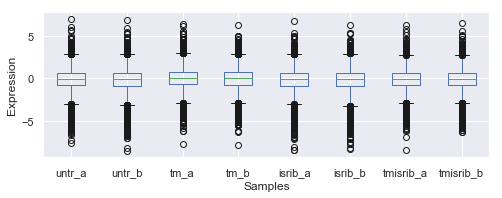

In [14]:
xp.check_samples(data_logte)

### Test accuracy of XPRESSpipe counts table vs Ingolia table

In [24]:
xpresspipe_table = pd.read_csv('isrib_counts_xpresspipe.tsv',sep='\t',index_col=0)
xpresspipe_table = xp.convert_names_gtf(xpresspipe_table, '/Users/jordan/Desktop/Homo_sapiens.GRCh38.95.gtf')

xpresspipe_table.head()

,trimmed_SRR1795409_1_final,trimmed_SRR1795410_1_final,trimmed_SRR1795411_1_final,trimmed_SRR1795412_1_final,trimmed_SRR1795413_1_final,trimmed_SRR1795414_1_final,trimmed_SRR1795415_1_final,trimmed_SRR1795416_1_final,trimmed_SRR1795417_1_final,trimmed_SRR1795418_1_final,...,trimmed_SRR1795431_1_final,trimmed_SRR1795432_1_final,trimmed_SRR1795433_1_final,trimmed_SRR1795434_1_final,trimmed_SRR1795435_1_final,trimmed_SRR1795436_1_final,trimmed_SRR1795437_1_final,trimmed_SRR1795438_1_final,trimmed_SRR1795439_1_final,trimmed_SRR1795440_1_final
TSPAN6,965,1169,1054,904,1236,999,841,599,944,956,...,378,217,315,216,180,175,459,328,505,352
TNMD,2,0,2,1,0,2,0,4,2,1,...,0,0,0,0,0,0,0,0,0,0
DPM1,505,614,566,518,630,501,394,342,436,427,...,791,441,613,489,391,306,918,727,1004,695
SCYL3,306,344,336,243,310,241,257,176,207,232,...,83,30,55,47,36,33,78,58,80,50
C1orf112,555,612,513,454,692,493,455,421,512,503,...,288,195,239,219,186,135,368,271,435,270


In [25]:
xpresspipe_table_deduped = xpresspipe_table[~xpresspipe_table.index.duplicated(keep='first')]
data_deduped = data[~data.index.duplicated(keep='first')]

xpresspipe_table_deduped = xpresspipe_table_deduped.dropna()
data_deduped = data_deduped.dropna()

xpresspipe_table_deduped = xpresspipe_table_deduped.reindex(labels=data_deduped.index.tolist())
data_deduped = data_deduped.reindex(labels=xpresspipe_table_deduped.index.tolist())

xpresspipe_table_deduped = xpresspipe_table_deduped.dropna()
data_deduped = data_deduped.dropna()

data_deduped = data_deduped.reindex(labels=xpresspipe_table_deduped.index.tolist())

print(xpresspipe_table_deduped.shape)
print(data_deduped.shape)

(10229, 32)
(10229, 16)


In [ ]:
gene_a = data_deduped.sum(axis=1).values.tolist()
gene_a = [x + 1 for x in gene_a]
gene_a = np.array(gene_a).astype(np.float)
gene_a = np.ndarray.tolist(gene_a)

gene_b = xpresspipe_table_deduped.sum(axis=1).values.tolist()
gene_b = [x + 1 for x in gene_b]
gene_b = np.array(gene_b).astype(np.float)
gene_b = np.ndarray.tolist(gene_b)

gene_a = np.log2(gene_a)
gene_b = np.log2(gene_b)

slope, intercept, r_value, p_value, std_err = stats.linregress(gene_a, gene_b)
x = np.linspace(np.amin(gene_a), np.amax(gene_b), 100)
y = (slope * x) + intercept

fig, ax = plt.subplots(1,1, figsize=(4,4))

ax.scatter(gene_a, gene_b, s=1,c='black')
ax.set_title('R = ' + str(r_value) + '\np-value ' + str(p_value))
ax.plot(x, y, '-r')

plt.show()

In [ ]:
gene_a = data_deduped.sum(axis=1).values.tolist()
gene_a = [x + 1 for x in gene_a]
gene_a = np.array(gene_a).astype(np.float)
gene_a = np.ndarray.tolist(gene_a)

gene_b = xpresspipe_table_deduped[xpresspipe_table_deduped.columns[1::2]].sum(axis=1).values.tolist()
gene_b = [x + 1 for x in gene_b]
gene_b = np.array(gene_b).astype(np.float)
gene_b = np.ndarray.tolist(gene_b)

gene_a = np.log2(gene_a)
gene_b = np.log2(gene_b)

slope, intercept, r_value, p_value, std_err = stats.linregress(gene_a, gene_b)
x = np.linspace(np.amin(gene_a), np.amax(gene_b), 100)
y = (slope * x) + intercept

fig, ax = plt.subplots(1,1, figsize=(4,4))

ax.scatter(gene_a, gene_b, s=1,c='black')
ax.set_title('R = ' + str(r_value) + '\np-value ' + str(p_value))
ax.plot(x, y, '-r')

plt.show()

In [ ]:
gene_a = data_deduped.sum(axis=1).values.tolist()
gene_a = [x + 1 for x in gene_a]
gene_a = np.array(gene_a).astype(np.float)
gene_a = np.ndarray.tolist(gene_a)

gene_b = xpresspipe_table_deduped[xpresspipe_table_deduped.columns[::2]].sum(axis=1).values.tolist()
gene_b = [x + 1 for x in gene_b]
gene_b = np.array(gene_b).astype(np.float)
gene_b = np.ndarray.tolist(gene_b)

gene_a = np.log2(gene_a)
gene_b = np.log2(gene_b)

slope, intercept, r_value, p_value, std_err = stats.linregress(gene_a, gene_b)
x = np.linspace(np.amin(gene_a), np.amax(gene_b), 100)
y = (slope * x) + intercept

fig, ax = plt.subplots(1,1, figsize=(4,4))

ax.scatter(gene_a, gene_b, s=1,c='black')
ax.set_title('R = ' + str(r_value) + '\np-value ' + str(p_value))
ax.plot(x, y, '-r')

plt.show()

In [ ]:
gene_a = data_deduped['isrib_a_hek_mrna'].values.tolist()
gene_a = [x + 1 for x in gene_a]
gene_a = np.array(gene_a).astype(np.float)
gene_a = np.ndarray.tolist(gene_a)

gene_b = xpresspipe_table_deduped['trimmed_SRR1795413_1_final'].values.tolist()
gene_b = [x + 1 for x in gene_b]
gene_b = np.array(gene_b).astype(np.float)
gene_b = np.ndarray.tolist(gene_b)

gene_a = np.log2(gene_a)
gene_b = np.log2(gene_b)

slope, intercept, r_value, p_value, std_err = stats.linregress(gene_a, gene_b)
x = np.linspace(np.amin(gene_a), np.amax(gene_b), 100)
y = (slope * x) + intercept

fig, ax = plt.subplots(1,1, figsize=(4,4))

ax.scatter(gene_a, gene_b, s=1,c='black')
ax.set_title('R = ' + str(r_value) + '\np-value ' + str(p_value))
ax.plot(x, y, '-r')

plt.show()

In [ ]:
gene_a = xpresspipe_table_deduped['trimmed_SRR1795429_1_final'].values.tolist()
gene_a = [x + 1 for x in gene_a]
gene_a = np.array(gene_a).astype(np.float)
gene_a = np.ndarray.tolist(gene_a)

gene_b = xpresspipe_table_deduped['trimmed_SRR1795413_1_final'].values.tolist()
gene_b = [x + 1 for x in gene_b]
gene_b = np.array(gene_b).astype(np.float)
gene_b = np.ndarray.tolist(gene_b)

gene_a = np.log2(gene_a)
gene_b = np.log2(gene_b)

slope, intercept, r_value, p_value, std_err = stats.linregress(gene_a, gene_b)
x = np.linspace(np.amin(gene_a), np.amax(gene_b), 100)
y = (slope * x) + intercept

fig, ax = plt.subplots(1,1, figsize=(4,4))

ax.scatter(gene_a, gene_b, s=1,c='black')
ax.set_title('R = ' + str(r_value) + '\np-value ' + str(p_value))
ax.plot(x, y, '-r')

plt.show()

### Reproduce Figure 1 from DOI: 10.7554/eLife.05033 (original paper)

##### Tm treatment vs Untreated

In [15]:
data_fig1a = data_rpm.copy()
data_fig1a = data_fig1a[['ribo_tm_a_ribo','ribo_tm_b_ribo','tm_a_hek_mrna','tm_b_hek_mrna',
                         'ribo_untr_a_ribo','ribo_untr_b_ribo','untr_a_hek_mrna','untr_b_hek_mrna']]

data_fig1a['ribo_tm'] = data_fig1a['ribo_tm_a_ribo'] + data_fig1a['ribo_tm_b_ribo']
data_fig1a['rna_tm'] = data_fig1a['tm_a_hek_mrna'] + data_fig1a['tm_b_hek_mrna']
data_fig1a['ribo_untr'] = data_fig1a['ribo_untr_a_ribo'] + data_fig1a['ribo_untr_b_ribo']
data_fig1a['rna_untr'] = data_fig1a['untr_a_hek_mrna'] + data_fig1a['untr_b_hek_mrna']

data_fig1a['ribo_fc'] = data_fig1a['ribo_tm'] / data_fig1a['ribo_untr']
data_fig1a['rna_fc'] = data_fig1a['rna_tm'] / data_fig1a['rna_untr']

data_fig1a_plot = data_fig1a[['ribo_fc','rna_fc']]

data_fig1a_plot = data_fig1a_plot[(data_fig1a_plot != 0).all(1)]
data_fig1a_plot = data_fig1a_plot.replace([np.inf, -np.inf], np.nan).dropna()

#Remove duplicate indices
data_fig1a_plot = data_fig1a_plot[~data_fig1a_plot.index.duplicated(keep='first')]

data_fig1a_plot.head()

,ribo_fc,rna_fc
LOC388312,0.646650,0.604092
SAMD11,0.876225,0.980238
NOC2L,1.073419,1.094396
KLHL17,1.033298,0.957411
HES4,0.708797,0.732429


In [16]:
data_fig1a = data_fig1a[(data_fig1a != 0).all(1)]
data_fig1a = data_fig1a.replace([np.inf, -np.inf], np.nan).dropna()

data_signif = xp.calculate_p(data_fig1a, 'ribo_tm_', 'ribo_untr_')
data_signif['p_value'] = 10 ** -data_signif['-log$_1$$_0$(P-Value)']

#Use R's padjust BH
stats = importr('stats')
p_adjust = stats.p_adjust(FloatVector(data_signif['p_value'].values.tolist()), method = 'BH')
data_signif['fdr'] = np.asarray(p_adjust).tolist()

/Users/jordan/scripts/XPRESSyourself/XPRESStools/xpresstools/utils_analyze.py:410: RuntimeWarning:

divide by zero encountered in log10



In [17]:
sig_list = data_signif.loc[data_signif['p_value'] < 0.05].index.tolist()
data_fig1a_threshold = data_fig1a_plot.reindex(labels=sig_list, axis=0)
print(data_fig1a_threshold.shape)

data_fig1a_orf = data_fig1a_plot.loc[['SLC35A4','PTP4A1','UCP2','PNRC2','C7orf31','BCL2L11','SAT1']]
print(data_fig1a_orf.shape)

data_fig1a_isr = data_fig1a_plot.loc[['ATF5','ATF4','DDIT3','PPP1R15A']]
print(data_fig1a_isr.shape)

(1340, 2)
(7, 2)
(4, 2)


<function matplotlib.pyplot.show(*args, **kw)>

<Figure size 432x288 with 0 Axes>

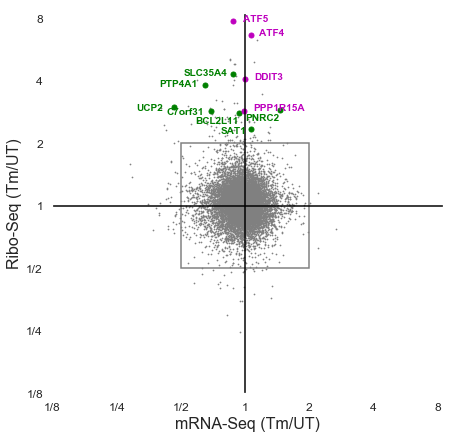

In [23]:
plt.close()
plt.clf()

#Prepare plot
fig, ax = plt.subplots(1,1, figsize=(7,7))
plt.grid(False)

for index, row in data_fig1a_orf.iterrows():
    if index == 'BCL2L11' or index == 'PNRC2':
        ax.text(row[1], row[0] - 0.3, str(index), horizontalalignment='right', size='medium', color='green', weight='semibold')
    else:
        ax.text(row[1] - 0.05, row[0] - 0.1, str(index), horizontalalignment='right', size='medium', color='green', weight='semibold')
for index, row in data_fig1a_isr.iterrows():
    ax.text(row[1] + 0.1, row[0] , str(index), horizontalalignment='left', size='medium', color='#be00be', weight='semibold')
    
    
ax.axhline(1, ls='-', color='black')
ax.axvline(1, ls='-', color='black')

rect = patches.Rectangle((.5,.5),1.5,1.5,linewidth=1.5,edgecolor='gray',facecolor='none')
ax.add_patch(rect)

ax.set_ylabel("Ribo-Seq (Tm/UT)", fontsize=16)
ax.set_xlabel("mRNA-Seq (Tm/UT)", fontsize=16)
ax.set_xlim(.125,8.5)
ax.set_ylim(.125,8.5)
ax.set_facecolor("#FFFFFF")

x = [.125,.250,.500,1,2,4,8]
ticks = ["1/8","1/4","1/2","1","2","4","8"]

ax.set_xscale('log', basex=2)
ax.set_xticks(x)
ax.set_xticklabels(ticks, fontsize=12)
ax.set_xticklabels([""]*len(x), minor=True)

ax.set_yscale('log', basey=2)
ax.set_yticks(x)
ax.set_yticklabels(ticks, fontsize=12)
ax.set_yticklabels([""]*len(x), minor=True)

#Prep data
#All
ribo_all = data_fig1a[['ribo_fc']].sum(axis=1).values.tolist()
ribo_all = np.array(ribo_all).astype(np.float)
ribo_all = np.ndarray.tolist(ribo_all)

rna_all = data_fig1a[['rna_fc']].sum(axis=1).values.tolist()
rna_all = np.array(rna_all).astype(np.float)
rna_all = np.ndarray.tolist(rna_all)

#ORFs
ribo_orf = data_fig1a_orf[['ribo_fc']].sum(axis=1).values.tolist()
ribo_orf = np.array(ribo_orf).astype(np.float)
ribo_orf = np.ndarray.tolist(ribo_orf)

rna_orf = data_fig1a_orf[['rna_fc']].sum(axis=1).values.tolist()
rna_orf = np.array(rna_orf).astype(np.float)
rna_orf = np.ndarray.tolist(rna_orf)

#ISR
ribo_isr = data_fig1a_isr[['ribo_fc']].sum(axis=1).values.tolist()
ribo_isr = np.array(ribo_isr).astype(np.float)
ribo_isr = np.ndarray.tolist(ribo_isr)

rna_isr = data_fig1a_isr[['rna_fc']].sum(axis=1).values.tolist()
rna_isr = np.array(rna_isr).astype(np.float)
rna_isr = np.ndarray.tolist(rna_isr)

#Plot data
ax.scatter(rna_all, ribo_all, s=.5,c='gray')
#ax.scatter(rna_thres, ribo_thres, s=5,c='black',alpha=0.7)
ax.scatter(rna_orf, ribo_orf, s=25,c='green')
ax.scatter(rna_isr, ribo_isr, s=25,c='#be00be')

plt.savefig('./plots/tm_1a.pdf', dpi=1800, bbox_inches='tight')

plt.show

##### Tm + ISRIB treament vs untreated

In [ ]:
data_fig1b = data_tpm.copy()
data_fig1b = data_fig1b[['ribo_tmisrib_a_ribo','ribo_tmisrib_b_ribo','tmisrib_a_hek_mrna','tmisrib_b_hek_mrna',
                         'ribo_untr_a_ribo','ribo_untr_b_ribo','untr_a_hek_mrna','untr_b_hek_mrna']]

data_fig1b['ribo_tmisrib'] = data_fig1b['ribo_tmisrib_a_ribo'] + data_fig1b['ribo_tmisrib_b_ribo']
data_fig1b['rna_tmisrib'] = data_fig1b['tmisrib_a_hek_mrna'] + data_fig1b['tmisrib_b_hek_mrna']
data_fig1b['ribo_untr'] = data_fig1b['ribo_untr_a_ribo'] + data_fig1b['ribo_untr_b_ribo']
data_fig1b['rna_untr'] = data_fig1b['untr_a_hek_mrna'] + data_fig1b['untr_b_hek_mrna']

data_fig1b['ribo_fc'] = data_fig1b['ribo_tmisrib'] / data_fig1b['ribo_untr']
data_fig1b['rna_fc'] = data_fig1b['rna_tmisrib'] / data_fig1b['rna_untr']

data_fig1b_plot = data_fig1b[['ribo_fc','rna_fc']]

data_fig1b_plot = data_fig1b_plot[(data_fig1b_plot != 0).all(1)]
data_fig1b_plot = data_fig1b_plot.replace([np.inf, -np.inf], np.nan).dropna()

#Remove duplicate indices
data_fig1b_plot = data_fig1b_plot[~data_fig1b_plot.index.duplicated(keep='first')]

data_fig1b_plot.head()

In [ ]:
data_fig1b = data_fig1b[(data_fig1b != 0).all(1)]
data_fig1b = data_fig1b.replace([np.inf, -np.inf], np.nan).dropna()

data_signif_1b = xp.calculate_p(data_fig1b, 'ribo_tmisrib_', 'ribo_untr_')
data_signif_1b['p_value'] = 10 ** -data_signif_1b['-log$_1$$_0$(P-Value)']

#Use R's padjust BH
stats = importr('stats')
p_adjust_1b = stats.p_adjust(FloatVector(data_signif_1b['p_value'].values.tolist()), method = 'BH')
data_signif_1b['fdr'] = np.asarray(p_adjust_1b).tolist()

In [ ]:
sig_list = data_signif_1b.loc[data_signif_1b['p_value'] < 0.05].index.tolist()
data_fig1b_threshold = data_fig1b_plot.reindex(labels=sig_list, axis=0)
print(data_fig1b_threshold.shape)

data_fig1b_orf = data_fig1b_plot.loc[['SLC35A4','PTP4A1','UCP2','PNRC2','C7orf31','BCL2L11','SAT1']]
print(data_fig1b_orf.shape)

data_fig1b_isr = data_fig1b_plot.loc[['ATF5','ATF4','DDIT3','PPP1R15A']]
print(data_fig1b_isr.shape)

In [ ]:
plt.close()
plt.clf()

#Prepare plot
fig, ax = plt.subplots(1,1, figsize=(7,7))
plt.grid(False)

for index, row in data_fig1b_orf.iterrows():
    ax.text(row[1] - 0.1, row[0] - 0.05, str(index), horizontalalignment='right', size='medium', color='green', weight='semibold')
for index, row in data_fig1b_isr.iterrows():
    if index == 'DDIT3':
        ax.text(row[1], row[0], str(index), horizontalalignment='right', size='medium', color='#be00be', weight='semibold')
    else:
        ax.text(row[1] + 0.1, row[0] , str(index), horizontalalignment='left', size='medium', color='#be00be', weight='semibold')
    
ax.axhline(1, ls='-', color='black')
ax.axvline(1, ls='-', color='black')

rect = patches.Rectangle((.5,.5),1.5,1.5,linewidth=1.5,edgecolor='gray',facecolor='none')
ax.add_patch(rect)

ax.set_ylabel("Ribo-Seq (Tm + ISRIB/UT)", fontsize=16)
ax.set_xlabel("mRNA-Seq (Tm + ISRIB/UT)", fontsize=16)
ax.set_xlim(.125,8.5)
ax.set_ylim(.125,8.5)
ax.set_facecolor("#FFFFFF")

x = [.125,.250,.500,1,2,4,8]
ticks = ["1/8","1/4","1/2","1","2","4","8"]

ax.set_xscale('log', basex=2)
ax.set_xticks(x)
ax.set_xticklabels(ticks, fontsize=12)
ax.set_xticklabels([""]*len(xm), minor=True)

ax.set_yscale('log', basey=2)
ax.set_yticks(x)
ax.set_yticklabels(ticks, fontsize=12)
ax.set_yticklabels([""]*len(xm), minor=True)

#Prep data
#All
ribo_all = data_fig1b[['ribo_fc']].sum(axis=1).values.tolist()
ribo_all = np.array(ribo_all).astype(np.float)
ribo_all = np.ndarray.tolist(ribo_all)

rna_all = data_fig1b[['rna_fc']].sum(axis=1).values.tolist()
rna_all = np.array(rna_all).astype(np.float)
rna_all = np.ndarray.tolist(rna_all)

#ORFs
ribo_orf = data_fig1b_orf[['ribo_fc']].sum(axis=1).values.tolist()
ribo_orf = np.array(ribo_orf).astype(np.float)
ribo_orf = np.ndarray.tolist(ribo_orf)

rna_orf = data_fig1b_orf[['rna_fc']].sum(axis=1).values.tolist()
rna_orf = np.array(rna_orf).astype(np.float)
rna_orf = np.ndarray.tolist(rna_orf)

#ISR
ribo_isr = data_fig1b_isr[['ribo_fc']].sum(axis=1).values.tolist()
ribo_isr = np.array(ribo_isr).astype(np.float)
ribo_isr = np.ndarray.tolist(ribo_isr)

rna_isr = data_fig1b_isr[['rna_fc']].sum(axis=1).values.tolist()
rna_isr = np.array(rna_isr).astype(np.float)
rna_isr = np.ndarray.tolist(rna_isr)

#Plot data
ax.scatter(rna_all, ribo_all, s=.5,c='gray')
#ax.scatter(rna_thres, ribo_thres, s=5,c='black',alpha=0.7)
ax.scatter(rna_orf, ribo_orf, s=25,c='green')
ax.scatter(rna_isr, ribo_isr, s=25,c='#be00be')

plt.savefig('./plots/tmisrib_1b.pdf', dpi=1800, bbox_inches='tight')

plt.show

##### ISRIB treament vs untreated

In [ ]:
data_fig1c = data_tpm.copy()
data_fig1c = data_fig1c[['ribo_isrib_a_ribo','ribo_isrib_b_ribo','isrib_a_hek_mrna','isrib_b_hek_mrna',
                         'ribo_untr_a_ribo','ribo_untr_b_ribo','untr_a_hek_mrna','untr_b_hek_mrna']]

data_fig1c['ribo_isrib'] = data_fig1c['ribo_isrib_a_ribo'] + data_fig1c['ribo_isrib_b_ribo']
data_fig1c['rna_isrib'] = data_fig1c['isrib_a_hek_mrna'] + data_fig1c['isrib_b_hek_mrna']
data_fig1c['ribo_untr'] = data_fig1c['ribo_untr_a_ribo'] + data_fig1c['ribo_untr_b_ribo']
data_fig1c['rna_untr'] = data_fig1c['untr_a_hek_mrna'] + data_fig1c['untr_b_hek_mrna']

data_fig1c['ribo_fc'] = data_fig1c['ribo_isrib'] / data_fig1c['ribo_untr']
data_fig1c['rna_fc'] = data_fig1c['rna_isrib'] / data_fig1c['rna_untr']

data_fig1c_plot = data_fig1c[['ribo_fc','rna_fc']]

data_fig1c_plot = data_fig1c_plot[(data_fig1c_plot != 0).all(1)]
data_fig1c_plot = data_fig1c_plot.replace([np.inf, -np.inf], np.nan).dropna()

#Remove duplicate indices
data_fig1c_plot = data_fig1c_plot[~data_fig1c_plot.index.duplicated(keep='first')]

data_fig1c_plot.head()

In [ ]:
data_fig1c = data_fig1c[(data_fig1c != 0).all(1)]
data_fig1c = data_fig1c.replace([np.inf, -np.inf], np.nan).dropna()

data_signif_1c = xp.calculate_p(data_fig1c, 'ribo_isrib_', 'ribo_untr_')
data_signif_1c['p_value'] = 10 ** -data_signif_1c['-log$_1$$_0$(P-Value)']

#Use R's padjust BH
stats = importr('stats')
p_adjust_1c = stats.p_adjust(FloatVector(data_signif_1c['p_value'].values.tolist()), method = 'BH')
data_signif_1c['fdr'] = np.asarray(p_adjust_1c).tolist()

In [ ]:
sig_list = data_signif_1c.loc[data_signif_1c['p_value'] < 0.05].index.tolist()
data_fig1c_threshold = data_fig1c_plot.reindex(labels=sig_list, axis=0)
print(data_fig1c_threshold.shape)

data_fig1c_orf = data_fig1c_plot.loc[['SLC35A4','PTP4A1','UCP2','PNRC2','C7orf31','BCL2L11','SAT1']]
print(data_fig1c_orf.shape)

data_fig1c_isr = data_fig1c_plot.loc[['ATF5','ATF4','DDIT3','PPP1R15A']]
print(data_fig1c_isr.shape)

In [ ]:
plt.close()
plt.clf()

#Prepare plot
fig, ax = plt.subplots(1,1, figsize=(7,7))
plt.grid(False)

for index, row in data_fig1c_orf.iterrows():
    ax.text(row[1] + 0.1, row[0], str(index), horizontalalignment='left', size='medium', color='green', weight='semibold')
for index, row in data_fig1c_isr.iterrows():
    ax.text(row[1] - 0.1, row[0] - 0.05, str(index), horizontalalignment='right', size='medium', color='#be00be', weight='semibold')

ax.axhline(1, ls='-', color='black')
ax.axvline(1, ls='-', color='black')

rect = patches.Rectangle((.5,.5),1.5,1.5,linewidth=1.5,edgecolor='gray',facecolor='none')
ax.add_patch(rect)

ax.set_ylabel("Ribo-Seq (ISRIB/UT)", fontsize=16)
ax.set_xlabel("mRNA-Seq (ISRIB/UT)", fontsize=16)
ax.set_xlim(.125,8.5)
ax.set_ylim(.125,8.5)
ax.set_facecolor("#FFFFFF")

x = [.125,.250,.500,1,2,4,8]
ticks = ["1/8","1/4","1/2","1","2","4","8"]

ax.set_xscale('log', basex=2)
ax.set_xticks(x)
ax.set_xticklabels(ticks, fontsize=12)
ax.set_xticklabels([""]*len(xm), minor=True)

ax.set_yscale('log', basey=2)
ax.set_yticks(x)
ax.set_yticklabels(ticks, fontsize=12)
ax.set_yticklabels([""]*len(xm), minor=True)

#Prep data
#All
ribo_all = data_fig1c[['ribo_fc']].sum(axis=1).values.tolist()
ribo_all = np.array(ribo_all).astype(np.float)
ribo_all = np.ndarray.tolist(ribo_all)

rna_all = data_fig1c[['rna_fc']].sum(axis=1).values.tolist()
rna_all = np.array(rna_all).astype(np.float)
rna_all = np.ndarray.tolist(rna_all)

#ORFs
ribo_orf = data_fig1c_orf[['ribo_fc']].sum(axis=1).values.tolist()
ribo_orf = np.array(ribo_orf).astype(np.float)
ribo_orf = np.ndarray.tolist(ribo_orf)

rna_orf = data_fig1c_orf[['rna_fc']].sum(axis=1).values.tolist()
rna_orf = np.array(rna_orf).astype(np.float)
rna_orf = np.ndarray.tolist(rna_orf)

#ISR
ribo_isr = data_fig1c_isr[['ribo_fc']].sum(axis=1).values.tolist()
ribo_isr = np.array(ribo_isr).astype(np.float)
ribo_isr = np.ndarray.tolist(ribo_isr)

rna_isr = data_fig1c_isr[['rna_fc']].sum(axis=1).values.tolist()
rna_isr = np.array(rna_isr).astype(np.float)
rna_isr = np.ndarray.tolist(rna_isr)

#Plot data
ax.scatter(rna_all, ribo_all, s=.5,c='gray')
#ax.scatter(rna_thres, ribo_thres, s=5,c='black',alpha=0.7)
ax.scatter(rna_orf, ribo_orf, s=25,c='green')
ax.scatter(rna_isr, ribo_isr, s=25,c='#be00be')

plt.savefig('./plots/isrib_1c.pdf', dpi=1800, bbox_inches='tight')

plt.show

### Metabolism analysis

In [ ]:
mitocarta = pd.read_csv('./human_mitocarta_gene_list.txt',sep='\t', header=None)
mitocarta = mitocarta[0].tolist()

enzymes = pd.read_csv('./reactome_metabolism_enzymes_gene_list.txt',sep='\t', header=None)
enzymes = enzymes[0].tolist()

##### Mitocarta

In [ ]:
data_fig1a_mitocarta = data_fig1a_plot.reindex(labels=mitocarta)
print(data_fig1a_mitocarta.shape)

In [ ]:
plt.close()
plt.clf()

#Prepare plot
fig, ax = plt.subplots(1,1, figsize=(7,7))
plt.grid(False)

ax.axhline(1, ls='-', color='black')
ax.axvline(1, ls='-', color='black')

ax.axhline(2, ls='--', color='gray')
ax.axhline(0.5, ls='--', color='gray')

ax.set_ylabel("Ribo-Seq (Tm/UT)", fontsize=16)
ax.set_xlabel("mRNA-Seq (Tm/UT)", fontsize=16)
ax.set_xlim(.125,8.5)
ax.set_ylim(.125,8.5)
ax.set_facecolor("#FFFFFF")

for index, row in data_fig1a_mitocarta.iterrows():
    if index == 'ACCS':
        ax.text(row[1] + 0.05, row[0], str(index), horizontalalignment='left', size='medium', color='#be00be', weight='semibold')
    elif index == 'CPT1B':
        ax.text(row[1] + 0.05, row[0] + 0.05, str(index), horizontalalignment='left', size='medium', color='#be00be', weight='semibold')
    elif index == 'NGRN':
        ax.text(row[1] + 0.05, row[0] - 0.05, str(index), horizontalalignment='left', size='medium', color='#be00be', weight='semibold')
    elif index == 'CPS1':
        ax.text(row[1] - 0.05, row[0] - 0.025, str(index), horizontalalignment='right', size='medium', color='#be00be', weight='semibold')
    elif index in ['SLMO1', 'UCP2', 'OBSCN']:
        ax.text(row[1] + 0.05, row[0] - 0.05, str(index), horizontalalignment='left', size='medium', color='#be00be', weight='semibold')
    elif index == 'MTHFD2L':
        ax.text(row[1] + 0.05, row[0] + 0.05, str(index), horizontalalignment='left', size='medium', color='#be00be', weight='semibold')
    else:
        pass

x = [.125,.250,.500,1,2,4,8]
ticks = ["1/8","1/4","1/2","1","2","4","8"]

ax.set_xscale('log', basex=2)
ax.set_xticks(x)
ax.set_xticklabels(ticks, fontsize=12)
ax.set_xticklabels([""]*len(xm), minor=True)

ax.set_yscale('log', basey=2)
ax.set_yticks(x)
ax.set_yticklabels(ticks, fontsize=12)
ax.set_yticklabels([""]*len(xm), minor=True)

#Prep data
#All
ribo_all = data_fig1a[['ribo_fc']].sum(axis=1).values.tolist()
ribo_all = np.array(ribo_all).astype(np.float)
ribo_all = np.ndarray.tolist(ribo_all)

rna_all = data_fig1a[['rna_fc']].sum(axis=1).values.tolist()
rna_all = np.array(rna_all).astype(np.float)
rna_all = np.ndarray.tolist(rna_all)

#ORFs
ribo_mito = data_fig1a_mitocarta[['ribo_fc']].sum(axis=1).values.tolist()
ribo_mito = np.array(ribo_mito).astype(np.float)
ribo_mito = np.ndarray.tolist(ribo_mito)

rna_mito = data_fig1a_mitocarta[['rna_fc']].sum(axis=1).values.tolist()
rna_mito = np.array(rna_mito).astype(np.float)
rna_mito = np.ndarray.tolist(rna_mito)

#Plot data
ax.scatter(rna_all, ribo_all, s=.5,c='gray')
ax.scatter(rna_mito, ribo_mito, s=10,c='#002c80')

plt.savefig('./plots/tm_mitocarta.pdf', dpi=1800, bbox_inches='tight')

plt.show

In [ ]:
data_fig1a_mitocarta.loc[data_fig1a_mitocarta['ribo_fc'] > 2]

In [ ]:
data_fig1a_mitocarta.loc[data_fig1a_mitocarta['ribo_fc'] < .5]

In [ ]:
data_fig1b_mitocarta = data_fig1b_plot.reindex(labels=mitocarta)
print(data_fig1b_mitocarta.shape)

In [ ]:
plt.close()
plt.clf()

#Prepare plot
fig, ax = plt.subplots(1,1, figsize=(7,7))
plt.grid(False)

ax.axhline(1, ls='-', color='black')
ax.axvline(1, ls='-', color='black')

ax.axhline(2, ls='--', color='gray')
ax.axhline(0.5, ls='--', color='gray')

ax.set_ylabel("Ribo-Seq (Tm + ISRIB/UT)", fontsize=16)
ax.set_xlabel("mRNA-Seq (Tm + ISRIB/UT)", fontsize=16)
ax.set_xlim(.125,8.5)
ax.set_ylim(.125,8.5)
ax.set_facecolor("#FFFFFF")

for index, row in data_fig1b_mitocarta.iterrows():
    if index == 'ACCS':
        ax.text(row[1] + 0.05, row[0], str(index), horizontalalignment='left', size='medium', color='#be00be', weight='semibold')
    elif index == 'CPT1B':
        ax.text(row[1] + 0.05, row[0] + 0.05, str(index), horizontalalignment='left', size='medium', color='#be00be', weight='semibold')
    elif index == 'NGRN':
        ax.text(row[1] + 0.05, row[0] - 0.05, str(index), horizontalalignment='left', size='medium', color='#be00be', weight='semibold')
    elif index == 'MTHFD2L':
        ax.text(row[1] - 0.05, row[0] - 0.05, str(index), horizontalalignment='right', size='medium', color='#be00be', weight='semibold')
    elif index ==  'UCP2':
        ax.text(row[1] - 0.05, row[0] - 0.05, str(index), horizontalalignment='right', size='medium', color='#be00be', weight='semibold')
    elif index == 'CPS1':
        ax.text(row[1] - 0.05, row[0] - 0.025, str(index), horizontalalignment='right', size='medium', color='#be00be', weight='semibold')
    elif index in ['SLMO1', 'OBSCN']:
        ax.text(row[1] + 0.05, row[0] - 0.05, str(index), horizontalalignment='left', size='medium', color='#be00be', weight='semibold')
    else:
        pass

x = [.125,.250,.500,1,2,4,8]
ticks = ["1/8","1/4","1/2","1","2","4","8"]

ax.set_xscale('log', basex=2)
ax.set_xticks(x)
ax.set_xticklabels(ticks, fontsize=12)
ax.set_xticklabels([""]*len(xm), minor=True)

ax.set_yscale('log', basey=2)
ax.set_yticks(x)
ax.set_yticklabels(ticks, fontsize=12)
ax.set_yticklabels([""]*len(xm), minor=True)

#Prep data
#All
ribo_all = data_fig1b[['ribo_fc']].sum(axis=1).values.tolist()
ribo_all = np.array(ribo_all).astype(np.float)
ribo_all = np.ndarray.tolist(ribo_all)

rna_all = data_fig1b[['rna_fc']].sum(axis=1).values.tolist()
rna_all = np.array(rna_all).astype(np.float)
rna_all = np.ndarray.tolist(rna_all)

#ORFs
ribo_mito = data_fig1b_mitocarta[['ribo_fc']].sum(axis=1).values.tolist()
ribo_mito = np.array(ribo_mito).astype(np.float)
ribo_mito = np.ndarray.tolist(ribo_mito)

rna_mito = data_fig1b_mitocarta[['rna_fc']].sum(axis=1).values.tolist()
rna_mito = np.array(rna_mito).astype(np.float)
rna_mito = np.ndarray.tolist(rna_mito)

#Plot data
ax.scatter(rna_all, ribo_all, s=.5,c='gray')
ax.scatter(rna_mito, ribo_mito, s=10,c='#002c80')

plt.savefig('./plots/tmisrib_mitocarta.pdf', dpi=1800, bbox_inches='tight')

plt.show

In [ ]:
data_fig1b_mitocarta.loc[data_fig1b_mitocarta['ribo_fc'] > 2]

In [ ]:
data_fig1b_mitocarta.loc[data_fig1b_mitocarta['ribo_fc'] < .5]

In [ ]:
data_fig1c_mitocarta = data_fig1c_plot.reindex(labels=mitocarta)
print(data_fig1c_mitocarta.shape)

In [ ]:
plt.close()
plt.clf()

#Prepare plot
fig, ax = plt.subplots(1,1, figsize=(7,7))
plt.grid(False)

ax.axhline(1, ls='-', color='black')
ax.axvline(1, ls='-', color='black')

ax.axhline(2, ls='--', color='gray')
ax.axhline(0.5, ls='--', color='gray')

ax.set_ylabel("Ribo-Seq (ISRIB/UT)", fontsize=16)
ax.set_xlabel("mRNA-Seq (ISRIB/UT)", fontsize=16)
ax.set_xlim(.125,8.5)
ax.set_ylim(.125,8.5)
ax.set_facecolor("#FFFFFF")

for index, row in data_fig1c_mitocarta.iterrows():
    if index == 'ACCS':
        ax.text(row[1] + 0.05, row[0], str(index), horizontalalignment='left', size='medium', color='#be00be', weight='semibold')
    elif index == 'CPT1B':
        ax.text(row[1] + 0.05, row[0] + 0.05, str(index), horizontalalignment='left', size='medium', color='#be00be', weight='semibold')
    elif index == 'NGRN':
        ax.text(row[1] + 0.05, row[0] - 0.05, str(index), horizontalalignment='left', size='medium', color='#be00be', weight='semibold')
    elif index == 'MTHFD2L':
        ax.text(row[1] - 0.05, row[0] - 0.05, str(index), horizontalalignment='right', size='medium', color='#be00be', weight='semibold')
    elif index ==  'UCP2':
        ax.text(row[1] - 0.05, row[0] - 0.05, str(index), horizontalalignment='right', size='medium', color='#be00be', weight='semibold')
    elif index == 'CPS1':
        ax.text(row[1] - 0.05, row[0] - 0.025, str(index), horizontalalignment='right', size='medium', color='#be00be', weight='semibold')
    elif index in ['SLMO1', 'OBSCN']:
        ax.text(row[1] + 0.05, row[0] - 0.05, str(index), horizontalalignment='left', size='medium', color='#be00be', weight='semibold')
    else:
        pass

x = [.125,.250,.500,1,2,4,8]
ticks = ["1/8","1/4","1/2","1","2","4","8"]

ax.set_xscale('log', basex=2)
ax.set_xticks(x)
ax.set_xticklabels(ticks, fontsize=12)
ax.set_xticklabels([""]*len(xm), minor=True)

ax.set_yscale('log', basey=2)
ax.set_yticks(x)
ax.set_yticklabels(ticks, fontsize=12)
ax.set_yticklabels([""]*len(xm), minor=True)

#Prep data
#All
ribo_all = data_fig1c[['ribo_fc']].sum(axis=1).values.tolist()
ribo_all = np.array(ribo_all).astype(np.float)
ribo_all = np.ndarray.tolist(ribo_all)

rna_all = data_fig1c[['rna_fc']].sum(axis=1).values.tolist()
rna_all = np.array(rna_all).astype(np.float)
rna_all = np.ndarray.tolist(rna_all)

#ORFs
ribo_mito = data_fig1c_mitocarta[['ribo_fc']].sum(axis=1).values.tolist()
ribo_mito = np.array(ribo_mito).astype(np.float)
ribo_mito = np.ndarray.tolist(ribo_mito)

rna_mito = data_fig1c_mitocarta[['rna_fc']].sum(axis=1).values.tolist()
rna_mito = np.array(rna_mito).astype(np.float)
rna_mito = np.ndarray.tolist(rna_mito)

#Plot data
ax.scatter(rna_all, ribo_all, s=.5,c='gray')
ax.scatter(rna_mito, ribo_mito, s=10,c='#002c80')

plt.savefig('./plots/isrib_mitocarta_1hr.pdf', dpi=1800, bbox_inches='tight')

plt.show

In [ ]:
data_fig1c_mitocarta.loc[data_fig1c_mitocarta['ribo_fc'] > 2]

In [ ]:
data_fig1c_mitocarta.loc[data_fig1c_mitocarta['ribo_fc'] < 0.5]

##### Metabolic Enzymes

In [ ]:
data_fig1a_enzymes = data_fig1a_plot.reindex(labels=enzymes)
print(data_fig1a_enzymes.shape)

In [ ]:
plt.close()
plt.clf()

#Prepare plot
fig, ax = plt.subplots(1,1, figsize=(7,7))
plt.grid(False)

ax.axhline(1, ls='-', color='black')
ax.axvline(1, ls='-', color='black')

ax.axhline(2, ls='--', color='gray')
ax.axhline(0.5, ls='--', color='gray')

ax.set_ylabel("Ribo-Seq (Tm/UT)", fontsize=16)
ax.set_xlabel("mRNA-Seq (Tm/UT)", fontsize=16)
ax.set_xlim(.125,8.5)
ax.set_ylim(.125,8.5)
ax.set_facecolor("#FFFFFF")



x = [.125,.250,.500,1,2,4,8]
ticks = ["1/8","1/4","1/2","1","2","4","8"]

ax.set_xscale('log', basex=2)
ax.set_xticks(x)
ax.set_xticklabels(ticks, fontsize=12)
ax.set_xticklabels([""]*len(xm), minor=True)

ax.set_yscale('log', basey=2)
ax.set_yticks(x)
ax.set_yticklabels(ticks, fontsize=12)
ax.set_yticklabels([""]*len(xm), minor=True)

#Prep data
#All
ribo_all = data_fig1a[['ribo_fc']].sum(axis=1).values.tolist()
ribo_all = np.array(ribo_all).astype(np.float)
ribo_all = np.ndarray.tolist(ribo_all)

rna_all = data_fig1a[['rna_fc']].sum(axis=1).values.tolist()
rna_all = np.array(rna_all).astype(np.float)
rna_all = np.ndarray.tolist(rna_all)

#ORFs
ribo_mito = data_fig1a_enzymes[['ribo_fc']].sum(axis=1).values.tolist()
ribo_mito = np.array(ribo_mito).astype(np.float)
ribo_mito = np.ndarray.tolist(ribo_mito)

rna_mito = data_fig1a_enzymes[['rna_fc']].sum(axis=1).values.tolist()
rna_mito = np.array(rna_mito).astype(np.float)
rna_mito = np.ndarray.tolist(rna_mito)

#Plot data
ax.scatter(rna_all, ribo_all, s=.5,c='gray')
ax.scatter(rna_mito, ribo_mito, s=10,c='#ffa500')

for index, row in data_fig1a_enzymes.iterrows():
    if index in [ 'CPS1', 'CPT1B', 'UCP2', 'ST3GAL3', 'OAZ1', 'SAT1', 'ABCA1', 'PLCD1', 'ADRA2C', 'PLCD1']:
        ax.text(row[1] + 0.025, row[0], str(index), horizontalalignment='left', size='medium', color='#016a86', weight='semibold')
    else:
        pass

plt.savefig('./plots/tm_enzymes.pdf', dpi=1800, bbox_inches='tight')

plt.show

In [ ]:
data_fig1a_enzymes.loc[data_fig1a_enzymes['ribo_fc'] > 2]

In [ ]:
data_fig1a_enzymes.loc[data_fig1a_enzymes['ribo_fc'] < 0.5]

In [ ]:
data_fig1b_enzymes = data_fig1b_plot.reindex(labels=enzymes)
print(data_fig1b_enzymes.shape)

In [ ]:
plt.close()
plt.clf()

#Prepare plot
fig, ax = plt.subplots(1,1, figsize=(7,7))
plt.grid(False)

ax.axhline(1, ls='-', color='black')
ax.axvline(1, ls='-', color='black')

ax.axhline(2, ls='--', color='gray')
ax.axhline(0.5, ls='--', color='gray')

ax.set_ylabel("Ribo-Seq (Tm + ISRIB/UT)", fontsize=16)
ax.set_xlabel("mRNA-Seq (Tm + ISRIB/UT)", fontsize=16)
ax.set_xlim(.125,8.5)
ax.set_ylim(.125,8.5)
ax.set_facecolor("#FFFFFF")

x = [.125,.250,.500,1,2,4,8]
ticks = ["1/8","1/4","1/2","1","2","4","8"]

ax.set_xscale('log', basex=2)
ax.set_xticks(x)
ax.set_xticklabels(ticks, fontsize=12)
ax.set_xticklabels([""]*len(xm), minor=True)

ax.set_yscale('log', basey=2)
ax.set_yticks(x)
ax.set_yticklabels(ticks, fontsize=12)
ax.set_yticklabels([""]*len(xm), minor=True)

#Prep data
#All
ribo_all = data_fig1b[['ribo_fc']].sum(axis=1).values.tolist()
ribo_all = np.array(ribo_all).astype(np.float)
ribo_all = np.ndarray.tolist(ribo_all)

rna_all = data_fig1b[['rna_fc']].sum(axis=1).values.tolist()
rna_all = np.array(rna_all).astype(np.float)
rna_all = np.ndarray.tolist(rna_all)

#ORFs
ribo_mito = data_fig1b_enzymes[['ribo_fc']].sum(axis=1).values.tolist()
ribo_mito = np.array(ribo_mito).astype(np.float)
ribo_mito = np.ndarray.tolist(ribo_mito)

rna_mito = data_fig1b_enzymes[['rna_fc']].sum(axis=1).values.tolist()
rna_mito = np.array(rna_mito).astype(np.float)
rna_mito = np.ndarray.tolist(rna_mito)

#Plot data
ax.scatter(rna_all, ribo_all, s=.5,c='gray')
ax.scatter(rna_mito, ribo_mito, s=10,c='#ffa500')

for index, row in data_fig1b_enzymes.iterrows():
    if index in [ 'CPS1', 'CPT1B', 'UCP2', 'ST3GAL3', 'OAZ1', 'SAT1', 'ABCA1', 'PLCD1', 'ADRA2C', 'PLCD1']:
        ax.text(row[1] + 0.025, row[0], str(index), horizontalalignment='left', size='medium', color='#016a86', weight='semibold')
    else:
        pass

plt.savefig('./plots/tmisrib_enzymes.pdf', dpi=1800, bbox_inches='tight')

plt.show

In [ ]:
data_fig1b_enzymes.loc['CHST2']

In [ ]:
data_fig1b_enzymes.loc[data_fig1b_enzymes['ribo_fc'] > 2]

In [ ]:
data_fig1b_enzymes.loc[data_fig1b_enzymes['ribo_fc'] < 0.5]

In [ ]:
data_fig1c_enzymes = data_fig1c_plot.reindex(labels=enzymes)
print(data_fig1c_enzymes.shape)

In [ ]:
plt.close()
plt.clf()

#Prepare plot
fig, ax = plt.subplots(1,1, figsize=(7,7))
plt.grid(False)

ax.axhline(1, ls='-', color='black')
ax.axvline(1, ls='-', color='black')

ax.axhline(2, ls='--', color='gray')
ax.axhline(0.5, ls='--', color='gray')

ax.set_ylabel("Ribo-Seq (ISRIB/UT)", fontsize=16)
ax.set_xlabel("mRNA-Seq (ISRIB/UT)", fontsize=16)
ax.set_xlim(.125,8.5)
ax.set_ylim(.125,8.5)
ax.set_facecolor("#FFFFFF")

x = [.125,.250,.500,1,2,4,8]
ticks = ["1/8","1/4","1/2","1","2","4","8"]

ax.set_xscale('log', basex=2)
ax.set_xticks(x)
ax.set_xticklabels(ticks, fontsize=12)
ax.set_xticklabels([""]*len(xm), minor=True)

ax.set_yscale('log', basey=2)
ax.set_yticks(x)
ax.set_yticklabels(ticks, fontsize=12)
ax.set_yticklabels([""]*len(xm), minor=True)

#Prep data
#All
ribo_all = data_fig1c[['ribo_fc']].sum(axis=1).values.tolist()
ribo_all = np.array(ribo_all).astype(np.float)
ribo_all = np.ndarray.tolist(ribo_all)

rna_all = data_fig1c[['rna_fc']].sum(axis=1).values.tolist()
rna_all = np.array(rna_all).astype(np.float)
rna_all = np.ndarray.tolist(rna_all)

#ORFs
ribo_mito = data_fig1c_enzymes[['ribo_fc']].sum(axis=1).values.tolist()
ribo_mito = np.array(ribo_mito).astype(np.float)
ribo_mito = np.ndarray.tolist(ribo_mito)

rna_mito = data_fig1c_enzymes[['rna_fc']].sum(axis=1).values.tolist()
rna_mito = np.array(rna_mito).astype(np.float)
rna_mito = np.ndarray.tolist(rna_mito)

#Plot data
ax.scatter(rna_all, ribo_all, s=.5,c='gray')
ax.scatter(rna_mito, ribo_mito, s=10,c='#ffa500')

for index, row in data_fig1c_enzymes.iterrows():
    if index in [ 'CPS1', 'CPT1B', 'UCP2', 'ST3GAL3', 'OAZ1', 'SAT1', 'ABCA1', 'PLCD1', 'ADRA2C', 'PLCD1']:
        ax.text(row[1] + 0.025, row[0], str(index), horizontalalignment='left', size='medium', color='#016a86', weight='semibold')
    else:
        pass
    
plt.savefig('./plots/isrib_enzymes.pdf', dpi=1800, bbox_inches='tight')

plt.show

In [ ]:
data_fig1c_enzymes.loc[data_fig1c_enzymes['ribo_fc'] > 2]

In [ ]:
data_fig1c_enzymes.loc[data_fig1c_enzymes['ribo_fc'] < 0.5]

##### Tracking analysis of gene groups

In [ ]:
data_logte_avg = data_logte.copy()

data_logte_avg['untr'] = (data_logte_avg['untr_a'] + data_logte_avg['untr_b']) / 2
data_logte_avg['tm'] = (data_logte_avg['tm_a'] + data_logte_avg['tm_b']) / 2
data_logte_avg['tmisrib'] = (data_logte_avg['tmisrib_a'] + data_logte_avg['tmisrib_b']) / 2
data_logte_avg['isrib'] = (data_logte_avg['isrib_a'] + data_logte_avg['isrib_b']) / 2

data_logte_avg = data_logte_avg[['untr','tm','tmisrib','isrib']]

data_logte_avg = data_logte_avg[~data_logte_avg.index.duplicated(keep='first')]

In [ ]:
data_logte_avg_mitocarta = data_logte_avg.reindex(labels=mitocarta)
print(data_logte_avg_mitocarta.shape)

In [ ]:
data_logte_avg_enzymes = data_logte_avg.reindex(labels=enzymes)
print(data_logte_avg_enzymes.shape)

In [ ]:
data_tpm.loc['NPIP']

In [ ]:
data_tpm_c = data_tpm.copy()

data_tpm_c['idx'] = data_tpm_c.index
data_tpm_c = data_tpm_c.sort_values(by=['idx'], axis=0)

data_tpm_c = data_tpm_c.groupby('idx').mean()

data_tpm_c.tail()

In [ ]:
(data_tpm_c.loc['NPIP']['ribo_isrib_a_ribo'] + data_tpm_c.loc['NPIP']['ribo_isrib_b_ribo']) / (data_tpm_c.loc['NPIP']['ribo_untr_a_ribo'] + data_tpm_c.loc['NPIP']['ribo_untr_b_ribo'])

In [ ]:
np.log(0.18118091020321184)

In [ ]:
data_tpm_c.loc['ST3GAL3']

In [ ]:
### TM
#Footprint
statistic, p_value = stats.ttest_ind([1.511040,1.549846], [0.967716,0.530006])
print(p_value)

#mRNA
statistic, p_value = stats.ttest_ind([6.674015,5.682717], [8.467867,6.772637])
print(p_value)

In [ ]:
### TM ISRIB
#Footprint
statistic, p_value = stats.ttest_ind([1.082089,0.724264], [0.967716,0.530006])
print(p_value)

#mRNA
statistic, p_value = stats.ttest_ind([6.043531,5.682717], [8.467867,6.772637])
print(p_value)

In [ ]:
data_tpm_c.loc['ADRA2C']

In [ ]:
### TM
#Footprint
statistic, p_value = stats.ttest_ind([0.790908,0.000000], [0.324174,0.388382])
print(p_value)

#mRNA
statistic, p_value = stats.ttest_ind([2.579677,3.118664], [2.319682,3.015436])
print(p_value)

In [ ]:
### TM ISRIB 
#Footprint
statistic, p_value = stats.ttest_ind([0.792941,1.010918], [0.324174,0.388382])
print(p_value)

#mRNA
statistic, p_value = stats.ttest_ind([3.317482,2.993154], [2.319682,3.015436])
print(p_value)

In [ ]:
data_tpm_c.loc['UCP2']

In [ ]:
### TM
#Footprint
statistic, p_value = stats.ttest_ind([31.412700,32.384651], [11.761092,9.153570])
print(p_value)

### TM ISRIB 
#Footprint
statistic, p_value = stats.ttest_ind([16.611926,12.045261], [11.761092,9.153570])
print(p_value)

In [ ]:
data_tpm_c.loc['SLMO1']

In [ ]:
### TM
#Footprint
statistic, p_value = stats.ttest_ind([10.534073,5.637184], [3.754487,3.052298])
print(p_value)

### TM ISRIB 
#Footprint
statistic, p_value = stats.ttest_ind([4.591804,2.927037], [3.754487,3.052298])
print(p_value)

In [ ]:
data_tpm_c.loc['MTHFD2L']

In [ ]:
### TM
#Footprint
statistic, p_value = stats.ttest_ind([8.545669,11.394674], [9.413403,6.444502])
print(p_value)

### TM ISRIB 
#Footprint
statistic, p_value = stats.ttest_ind([3.365857,4.505673], [9.413403,6.444502])
print(p_value)